## RFM Analysis for Customer Segmentation

RFM segmentation will make you able to understand your customer base better, and also serve as a good starting point for your data journey and more advanced customer models. You will be able to give more accurate answers to key questions for your business — 

* Who are your best customers?
* Which customers are at the verge of churning?
* Who has the potential to be converted in more profitable customers
* Which customer are lost/inactive?
* Which customers is critical to retain?
* Who are your loyal customers?
* Which group of customers is most likely to respond to your current campaign?

RMF is a simple statistical method for categorising customers based on their purchasing behaviour. The behaviour is identified by using only three customer data points: 
* the recency of purchase (R), 
* the frequency of purchases (F) and 
* the mean monetary value of each purchase (M).

### Here, we have take the OnlineRetail Dataset for Understanding the Customer behaviour through RFM model

#### 1. Preparing the Data

In [ ]:
from __future__ import division

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objs as go
from lifetimes.utils import summary_data_from_transaction_data

# Read the data
df = pd.read_csv('F:\\python\\OnlineRetail.csv', error_bad_lines=False, encoding= 'unicode_escape')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
print((df['Quantity']< 0).value_counts())
print('\n')
print((df['UnitPrice']< 0).value_counts())

False    531285
True      10624
Name: Quantity, dtype: int64


False    541907
True          2
Name: UnitPrice, dtype: int64


In [ ]:
df["Country"].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [ ]:
# Filter on Unite Kingdom to get a clean cohort
# Behaviour across nations can be influenced by different campaigns, discounts, shipping fees etc.
# We also avoid possible difficulties with different currencies.
df = df[df['Country']=='United Kingdom']
#Transform to proper datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove records with no CustomerID
df = df[~df['CustomerID'].isna()]

# Remove negative/0 quantities and prices
df = df[df['Quantity']>0]
df = df[df['UnitPrice']>0]

# Create sum column for each order line
df['InvoiceSum'] = df['Quantity']*df['UnitPrice']

# Create a new data frame grouped by InvoiceNo
orders = df.groupby(['InvoiceNo', 'InvoiceDate']).sum().reset_index()

In [ ]:
df.head() # cleaned dataset

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### 2. Creating the RFM model from the transaction data


Calculating RFM Values


In order to create the RFM score, we must get the individual data points for each customer’s recency, frequency and monetary value. They are defined as follows:
* Recency: The age of the customer at the last transaction. This is slightly different from vanilla RFM where recency is calculated as the number of days since last purchase.
* Frequency: The number of purchases within the customers life span
* Monetary value: The mean monetary value for the customers transactions.
The results after this step should be an RFM summary table with a unique customer id and the data for recency, frequency and mean monetary value.

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID,InvoiceSum
count,354321.000000,354321.000000,354321.000000,354321.000000
mean,12.013795,2.963994,15552.486392,20.626470
std,189.267956,17.862655,1594.527150,326.044012
min,1.000000,0.001000,12346.000000,0.001000
25%,2.000000,1.250000,14194.000000,4.160000
50%,4.000000,1.950000,15522.000000,10.200000
75%,12.000000,3.750000,16931.000000,17.700000
max,80995.000000,8142.750000,18287.000000,168469.600000


In [ ]:
df_1=df[df["InvoiceSum"]>2000]
df_1['InvoiceSum'].unique()

array([  2245.32,   2603.04,   2328.48,   3828.  ,   2868.  ,   2353.68,
         2978.4 ,   2256.  ,   2786.4 ,   3272.4 ,   2617.08,   4121.64,
         4921.5 ,   3700.  ,   6539.4 ,   3315.  ,   4522.5 ,  77183.6 ,
         3215.52,   3202.92,   2076.8 ,   4632.  ,   2730.  ,   4254.5 ,
         3380.  ,   8142.75,   3160.08,   2388.72,   2131.2 ,   3096.  ,
        38970.  ,   2496.  ,   4401.  ,   2610.  ,   2390.4 ,   2232.  ,
         2102.4 ,   3129.6 ,   2662.2 ,   4176.  ,   2500.  ,   2033.1 ,
         2748.  ,   2061.  ,   2290.  ,   2704.  ,   2529.6 ,   3035.52,
         2121.6 ,   2028.24,   2099.52,   3825.36,   2959.44,   2427.6 ,
         3621.  ,   3170.16,   7144.72,   3155.95,   3285.  ,   3174.4 ,
         2601.  ,   2226.  ,   2432.  ,   2685.  ,   2046.  ,   2002.5 ,
         3861.  ,   3254.4 ,   2896.7 , 168469.6 ])

In [ ]:
# Create the rfm summary table from litetimes utility function
rfm = summary_data_from_transaction_data(orders, 'CustomerID', 'InvoiceDate', monetary_value_col='InvoiceSum').reset_index()

# Filter out non repeat customers
print("Non Repeating Customers : ",(rfm['frequency']==0).value_counts())
rfm = rfm[rfm['frequency']>0]

# Filter out monetary outliers
rfm = rfm[rfm['monetary_value']<2000]

# Create the quartiles scores
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
    
def RFMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
rfm['R'] = rfm['recency'].apply(RFMScore, args=('recency',quantiles,))
rfm['F'] = rfm['frequency'].apply(RFMScore, args=('frequency',quantiles,))
rfm['M'] = rfm['monetary_value'].apply(RFMScore, args=('monetary_value',quantiles,))

# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)

Non Repeating Customers :  True     11361
False     1957
Name: frequency, dtype: int64


In [ ]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

# Create human friendly RFM labels
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][2-3]': 'At risk',
    r'[1-2]4': 'Can\'t loose them',
    r'2[1-2]': 'About to sleep',
    r'22': 'Need attention',
    r'[2-3][3-4]': 'Loyal customers',
    r'31': 'Promising',
    r'41': 'New customers',
    r'[3-4][1-2]': 'Potential loyalists',
    r'4[3-4]': 'Champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)

# Create some human friendly labels for the scores
rfm['Score'] = 'Green'
rfm.loc[rfm['RFM_Score']>5,'Score'] = 'Bronze' 
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Silver' 
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Gold' 
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Platinum'

# List the head of the table to view the 
rfm.head(189)

,CustomerID,frequency,recency,T,monetary_value,R,F,M,RFM_Segment,RFM_Score,Segment,Score
1,12748.0,26.0,366.0,373.0,56.464615,4,4,1,441,9,Champions,Silver
3,12823.0,4.0,222.0,296.0,363.375000,4,4,3,443,11,Champions,Platinum
6,12843.0,1.0,103.0,168.0,9.950000,2,1,1,211,4,Hibernating,Green
7,12845.0,1.0,3.0,270.0,73.500000,1,1,1,111,3,Hibernating,Green
9,12875.0,1.0,219.0,362.0,49.470000,3,1,1,311,5,Promising,Green
...,...,...,...,...,...,...,...,...,...,...,...,...
602,17736.0,1.0,33.0,42.0,30.000000,1,1,1,111,3,Hibernating,Green
610,17809.0,5.0,357.0,373.0,227.560000,4,4,2,442,10,Champions,Gold
614,17841.0,6.0,304.0,327.0,8.701667,4,4,1,441,9,Champions,Silver
616,17848.0,1.0,47.0,128.0,79.600000,1,1,1,111,3,Hibernating,Green


We are only going to use frequency,recency and monetary_value columns when segmenting.T column(age of customer) is only used internally to calculate the value of recency and will not be used for future calculation

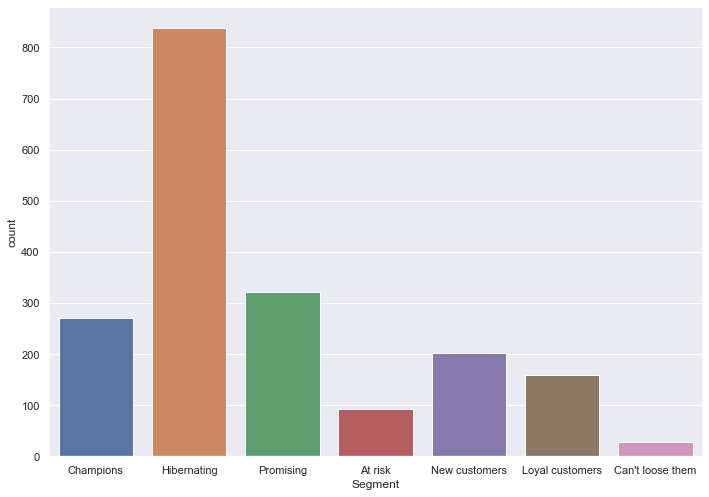

In [ ]:
import seaborn as sns
sns.set(style="darkgrid",rc={'figure.figsize':(11.7,8.27)})
ax=sns.countplot(x="Segment",data=rfm )

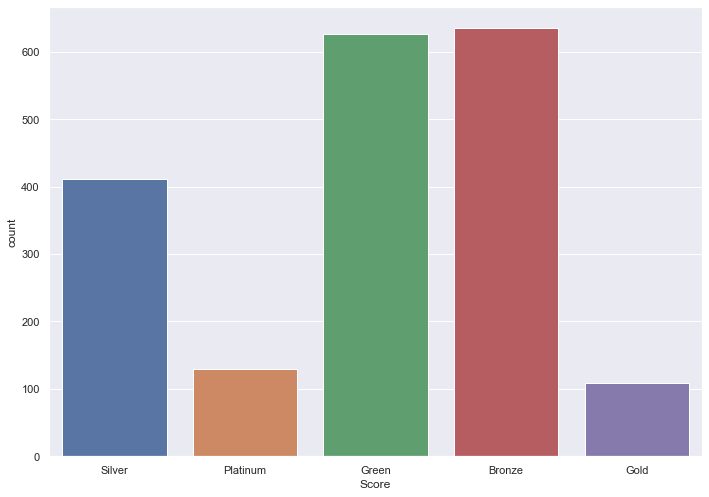

In [ ]:
sns.set(style="darkgrid",rc={'figure.figsize':(11.7,8.27)})
ax=sns.countplot(x="Score",data=rfm )

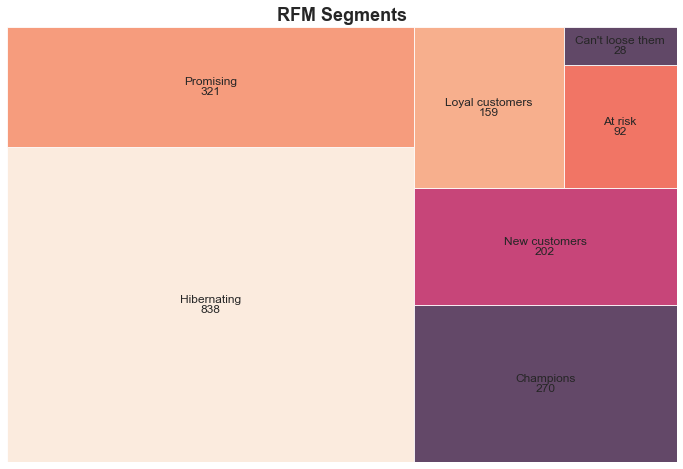

In [ ]:
#Create our RFM Segment plot and resize it.
import matplotlib.pyplot as plt
import squarify

fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
squarify.plot(sizes=rfm['Segment'].value_counts(), 
              label=['Hibernating','Promising','Champions','New customers','Loyal customers',
                      'At risk','Can\'t loose them',],value=rfm['Segment'].value_counts(),alpha=0.8 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
rfm_ = summary_data_from_transaction_data(orders, 'CustomerID', 'InvoiceDate', monetary_value_col='InvoiceSum').reset_index()

rfm__ = rfm_[rfm_['frequency']<=0]
rfm__

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.0
2,12749.0,0.0,0.0,130.0,0.0
4,12830.0,0.0,0.0,134.0,0.0
5,12841.0,0.0,0.0,4.0,0.0
8,12853.0,0.0,0.0,134.0,0.0
...,...,...,...,...,...
13313,6131760.0,0.0,0.0,39.0,0.0
13314,6230432.0,0.0,0.0,16.0,0.0
13315,7456784.0,0.0,0.0,4.0,0.0
13316,7513168.0,0.0,0.0,11.0,0.0


In [ ]:
rfm['monetary_value'].groupby(rfm['Segment']).sum()

Segment
At risk              38960.500000
Can't loose them     10400.673333
Champions            95592.994615
Hibernating         262808.030000
Loyal customers      56773.703167
New customers        62899.600000
Promising           111276.560000
Name: monetary_value, dtype: float64

In [ ]:
import datetime as dt
#df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format="%d/%m/%y %H:%M:%S")


def extract_days(x):

    return dt.datetime(x.year, x.month, x.day)

df['Date'] = df['InvoiceDate'].apply(extract_days)


In [ ]:
df['Date']

0        2010-12-01
1        2010-12-01
2        2010-12-01
3        2010-12-01
4        2010-12-01
            ...    
541889   2011-12-09
541890   2011-12-09
541891   2011-12-09
541892   2011-12-09
541893   2011-12-09
Name: Date, Length: 354321, dtype: datetime64[ns]

In [ ]:
import datetime as dt
#df.Date = pd.to_datetime(df.Date, format="%d/%m/%y %H:%M:%S")


df['seniority'] = (df['Date']).dt.day 

df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceSum,Date,InvoiceDay,seniority
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50,2010-12-01,2010-12-01,1
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10,2010-12-01,2010-12-01,1
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10,2010-12-01,2010-12-01,1
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08,2010-12-01,2010-12-01,1


In [ ]:
# Get the integers for date parts from 'InvoiceDay' column and 'CohortDay' column

def extract_month_int(x):
    return dt.datetime(x.year, x.month, 1)

df['InvoiceMonth_'] = df['InvoiceDate'].apply(extract_month_int)

grouping = df.groupby('CustomerID')['InvoiceMonth_']

# Assign new column
df['CohortMonth'] = grouping.transform('min')

In [ ]:
def extract_dates_int(df, column):
    year = df[column].dt.year
    
    # extract months from datetime column
    month = df[column].dt.month
    
    # extract days from datetime column
    day = df[column].dt.day
    
    return year, month, day

In [ ]:
# InvoiceDay column manipulation
invoice_year, invoice_month, _ = extract_dates_int(df, 'InvoiceMonth_')

# CohortDay column manipulation
cohort_year, cohort_month, _ = extract_dates_int(df, 'CohortMonth')

In [ ]:
# calculation of the difference in years
years_difference = invoice_year - cohort_year

# calculation of the difference in months
months_difference = invoice_month - cohort_month

In [ ]:
# Extract the difference in days from all the previous extracted values above and create 
# new column called CohortIndex

# ~365 days in one year, ~30 days in one month and plus 1 day to differ from zero value
df['Seniority'] = years_difference * 12 + months_difference + 1
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceSum,Date,InvoiceDay,seniority,CohortMonth,CohortIndex,Seniority,InvoiceMonth_
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1,2010-12-01,1,1,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,2010-12-01,1,1,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1,2010-12-01,1,1,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,2010-12-01,1,1,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,2010-12-01,1,1,2010-12-01


In [ ]:
df['Seniority'].unique

<bound method Series.unique of 0          1
1          1
2          1
3          1
4          1
          ..
541889     8
541890    13
541891    13
541892    13
541893    13
Name: Seniority, Length: 354321, dtype: int64>

In [ ]:
grouping = df.groupby(['CohortMonth', 'Seniority'])

# Count the number of unique values per CustomerID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Creating cohort pivot table 
cohort_counts = cohort_data.pivot(index = 'CohortMonth', columns = 'Seniority', values = 'CustomerID')

# Review the results
cohort_counts


Seniority,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Select the first column and store value in cohort_sizes
cohort_sizes = cohort_counts.iloc[:, 0]

# Calculate Retention table by dividing the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis = 0)

# Review the retention table
retention.round(3) * 100

Seniority,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,35.5,32.3,37.3,36.0,39.6,35.7,34.1,35.5,39.9,36.7,49.7,26.7
2011-01-01,100.0,21.2,26.0,23.5,33.2,27.7,25.1,24.3,30.2,32.7,35.5,12.0,NaN
2011-02-01,100.0,18.8,19.4,28.5,28.8,25.3,25.6,28.2,26.5,30.6,7.4,NaN,NaN
2011-03-01,100.0,15.3,26.0,19.8,22.4,16.5,26.5,22.9,28.4,9.1,NaN,NaN,NaN
2011-04-01,100.0,20.9,20.2,21.7,20.2,22.0,22.0,26.4,7.2,NaN,NaN,NaN,NaN
2011-05-01,100.0,18.8,17.2,17.2,20.7,22.7,26.6,9.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.8,14.5,23.8,23.8,32.2,9.8,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,17.8,19.5,23.1,27.8,10.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,22.7,22.7,24.1,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
